In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000


TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'

INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER

value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)


df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (12702, 8)
Successfully added technical indicators
Successfully added turbulence index


# Portfolio Optimization Algorithm

In [2]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.35181855 0.27963358 0.2540565  0.27536942 0.22213764 0.20050276
 0.21795821 0.22398526 0.18140366 0.19971953 0.21862941 0.18288069
 0.25173724 0.25655932 0.20846969 0.20647458 0.16977883 0.22140022
 0.20087649 0.20671056 0.24370411 0.37134127 0.48436472 0.2192115
 0.26146174 0.20120535 0.1757472  0.18027714 0.19517704 0.19363506
 0.20576698 0.21390712 0.18559093 0.18472204 0.16007065 0.15185834
 0.17406055 0.14120282 0.15861371 0.17409005 0.16392028 0.22195407
 0.27475219 0.17629603 0.14812607 0.16892688 0.21517642 0.26502173
 0.23125368 0.24214863 0.23898934 0.31048271 0.23108266 0.23201432
 0.23754809 0.21219443 0.18575536 0.16439788 0.14432099 0.16099446
 0.15533361 0.21573309 0.17878818 0.14521876 0.16164088 0.14243164
 0.14973301 0.14950488 0.1573

In [3]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load("policy_EIIE.pt"))

C:\Users\bencj\AppData\Local\Temp\ipykernel_10960\3962532677.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load("policy_EIIE.pt"))


<All keys matched successfully>

In [4]:
EIIE_results = {
    "20212024": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["20212024"]["value"] = environment._asset_memory["final"]
EIIE_results["20212024"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["20212024"]["value"], columns=['opt_net_worth'])
df_date = pd.DataFrame(EIIE_results["20212024"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1218662.875
Final accumulative portfolio value: 1.218662875
Maximum DrawDown: -0.08721349916625476
Sharpe ratio: 1.1430793966698658
Total commission cost: 3912.0300503576873


In [5]:
print(df_opt)

     opt_net_worth       Date
0     1.000000e+06 2023-02-07
1     9.923262e+05 2023-02-08
2     9.847312e+05 2023-02-09
3     9.893354e+05 2023-02-10
4     1.001233e+06 2023-02-13
..             ...        ...
409   1.211156e+06 2024-09-24
410   1.204903e+06 2024-09-25
411   1.212727e+06 2024-09-26
412   1.219512e+06 2024-09-27
413   1.218663e+06 2024-09-30

[414 rows x 2 columns]


In [6]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2023-02-07 00:00:00
2024-09-30 00:00:00


# PPO On portfolio Opt

In [7]:
from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up, TODO fix this for real dates
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test = data_split(portfolio_norm_df, new_opt_start_str,opt_end)


portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test)
portfolio_norm_df


environment_ppo = PortfolioOptStableEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low", 'macd',
            'rsi_30',
            'cci_30',
            'dx_30'],
    normalize_df=None
)

In [8]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR


# Load the trained models
# trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_10_27") 

trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + "/agent_opt_ppo_20092021_features_11_1") 

In [9]:
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent


PPO_results = {
    "20212024": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo)
PPO_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["20212024"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["20212024"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["20212024"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_ppo_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_ppo_opt.loc[len(df_ppo_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1218400.0
Final accumulative portfolio value: 1.2184
Maximum DrawDown: -0.08631822334472816
Sharpe ratio: 1.1210863148921457
Total commission cost: 3846.8853677919833
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2023-02-07
1         9.925606e+05 2023-02-08
2         9.860537e+05 2023-02-09
3         9.890504e+05 2023-02-10
4         1.000405e+06 2023-02-13
..                 ...        ...
409       1.211406e+06 2024-09-24
410       1.205068e+06 2024-09-25
411       1.214315e+06 2024-09-26
412       1.220542e+06 2024-09-27
413       1.218400e+06 2024-09-30

[414 rows x 2 columns]


In [10]:
df_ppo_opt.loc[0, 'Date']

Timestamp('2023-02-07 00:00:00')

In [11]:
df_opt.loc[0,'Date']

Timestamp('2023-02-07 00:00:00')

# Porfolio Baselines

In [12]:
# CRP 

CRP_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_crp = DRLStableAgent(env = environment_ppo)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_ppo)
CRP_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
CRP_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["20212024"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["20212024"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1218665.75
Final accumulative portfolio value: 1.21866575
Maximum DrawDown: -0.08721614497467833
Sharpe ratio: 1.1430716045785774
Total commission cost: 3912.1155717684887
hit end!
     crp_opt_net_worth       Date
0          1000000.000 2023-02-07
1           992326.125 2023-02-08
2           984731.125 2023-02-09
3           989335.375 2023-02-10
4          1001233.250 2023-02-13
..                 ...        ...
409        1211159.250 2024-09-24
410        1204905.750 2024-09-25
411        1212730.125 2024-09-26
412        1219515.000 2024-09-27
413        1218665.750 2024-09-30

[414 rows x 2 columns]


In [13]:
# BAH

BAH_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_bah = DRLStableAgent(env = environment_ppo)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_ppo)
BAH_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BAH_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["20212024"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["20212024"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

[0.         0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1240770.125
Final accumulative portfolio value: 1.240770125
Maximum DrawDown: -0.08524969413273342
Sharpe ratio: 1.2662263005202756
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2023-02-07
1         9.923261e+05 2023-02-08
2         9.847566e+05 2023-02-09
3         9.893321e+05 2023-02-10
4         1.001191e+06 2023-02-13
..                 ...        ...
409       1.235141e+06 2024-09-24
410       1.229528e+06 2024-09-25
411       1.236323e+06 2024-09-26
412       1.240196e+06 2024-09-27
413       1.240770e+06 2024-09-30

[414 rows x 2 columns]


In [14]:
# OLMAR

OLMAR_results = {
    "20212024": {},
}

OLMAR_kwargs = {
    "eps": 10
}


environment_ppo.reset()
agent_olmar = DRLStableAgent(env = environment_ppo)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_ppo)
OLMAR_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
OLMAR_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["20212024"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["20212024"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1017686.4375
Final accumulative portfolio value: 1.0176864375
Maximum DrawDown: -0.29634723239397975
Sharpe ratio: 0.19316979248298308
Total commission cost: 530923.8047949041
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2023-02-07
1           9.842364e+05 2023-02-08
2           9.681319e+05 2023-02-09
3           9.881464e+05 2023-02-10
4           9.965369e+05 2023-02-13
..                   ...        ...
409         9.922206e+05 2024-09-24
410         9.788021e+05 2024-09-25
411         9.963288e+05 2024-09-26
412         1.007476e+06 2024-09-27
413         1.017686e+06 2024-09-30

[414 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [15]:
# bcrp

BCRP_results = {
    "20212024": {},
}

environment_ppo.reset()
agent_bcrp= DRLStableAgent(env = environment_ppo)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_ppo)
BCRP_results["20212024"]["value"] = environment_ppo._terminal_asset_memory["final"]
BCRP_results["20212024"]["date"] = environment_ppo._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["20212024"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["20212024"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1605119.125
Final accumulative portfolio value: 1.605119125
Maximum DrawDown: -0.3111121921523836
Sharpe ratio: 1.0583008387229396
Total commission cost: 6.35860487818718e-07
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2023-02-07
1          9.903667e+05 2023-02-08
2          1.013895e+06 2023-02-09
3          9.751869e+05 2023-02-10
4          9.988324e+05 2023-02-13
..                  ...        ...
409        1.585943e+06 2024-09-24
410        1.607348e+06 2024-09-25
411        1.617141e+06 2024-09-26
412        1.622302e+06 2024-09-27
413        1.605119e+06 2024-09-30

[414 rows x 2 columns]


# Stock environment optimization algorithm

In [16]:
# from finrl.meta.preprocessor.preprocessors import data_split

# Make sure we only test on the same data as the portfolio optimization algorithm
# test = data_split(test, opt_start,opt_end)


In [17]:
# from stable_baselines3 import PPO, TD3, A2C
# from finrl.config import TRAINED_MODEL_DIR


# # Load the trained models
# trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") 

# trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") 

# trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") 

In [18]:
# # Test out of sample performance

# stock_dimension = len(test.tic.unique())
# state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
# print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

In [19]:
# buy_cost_list = sell_cost_list = [COMMISSION_FEE_PERCENT] * stock_dimension
# num_stock_shares = [0] * stock_dimension

# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": INITIAL_CASH,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

In [20]:
# e_trade_gym_ppo = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_ppo, df_actions_ppo = StockDRLAgent.DRL_prediction(
#     model=trained_ppo, 
#     environment = e_trade_gym_ppo,
#     deterministic=True)

In [21]:
# df_account_value_ppo.rename(columns={'date': 'Date', 'account_value' : "ppo_value"}, inplace=True)
# df_account_value_ppo

In [22]:
# e_trade_gym_td3 = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_td3, df_actions_td3 = StockDRLAgent.DRL_prediction(
#     model=trained_td3, 
#     environment = e_trade_gym_td3)

In [23]:
# df_account_value_td3.rename(columns={'date': 'Date', 'account_value' : "td3_value"}, inplace=True)
# df_account_value_td3

In [24]:

# e_trade_gym_a2c = StockTradingEnv(df = test, turbulence_threshold = 70, **env_kwargs)

# df_account_value_a2c, df_actions_a2c = StockDRLAgent.DRL_prediction(
#     model=trained_a2c, 
#     environment = e_trade_gym_a2c)

# df_account_value_a2c.rename(columns={'date': 'Date', 'account_value' : "a2c_value"}, inplace=True)
# df_account_value_a2c

In [25]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (413, 8)
Annual return          0.139579
Cumulative returns     0.238791
Annual volatility      0.110230
Sharpe ratio           1.243522
Calmar ratio           1.547827
Stability              0.874604
Max drawdown          -0.090178
Omega ratio            1.226037
Sortino ratio          1.819175
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.072210
Daily value at risk   -0.013344
dtype: float64
df_dji:            date           dji
0   2023-02-07  1.000000e+06
1   2023-02-08  9.939198e+05
2   2023-02-09  9.866260e+05
3   2023-02-10  9.915852e+05
4   2023-02-13  1.002613e+06
..         ...           ...
409 2024-09-24  1.235723e+06
410 2024-09-25  1.227131e+06
411 2024-09-26  1.234754e+06
412 2024-09-27  1.238791e+06
413 2024-09-30           NaN

[414 rows x 2 columns]
df_dji:                       dji
date                    
2023-02-07  1.000000e+06
2023-02-08  9.939198e+05
2023-02-09  9.866260e+05
2023-02-10  9.915852e+05

# Compare all results

In [26]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO opt algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')




print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2023-02-07  1.000000e+06
2023-02-08  9.939198e+05
2023-02-09  9.866260e+05
2023-02-10  9.915852e+05
2023-02-13  1.002613e+06
...                  ...
2024-09-24  1.235723e+06
2024-09-25  1.227131e+06
2024-09-26  1.234754e+06
2024-09-27  1.238791e+06
2024-09-30           NaN

[414 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0          1000000.000 2023-02-07        1.000000e+06       1.000000e+06   
1           992326.125 2023-02-08        9.903667e+05       9.923261e+05   
2           984731.125 2023-02-09        1.013895e+06       9.847566e+05   
3           989335.375 2023-02-10        9.751869e+05       9.893321e+05   
4          1001233.250 2023-02-13        9.988324e+05       1.001191e+06   
..                 ...        ...                 ...                ...   
409        1211159.250 2024-09-24        1.585943e+06       1.235141e+06   
410        1204905.750 2024-09-25        1.

# Baseline CRP in the environment

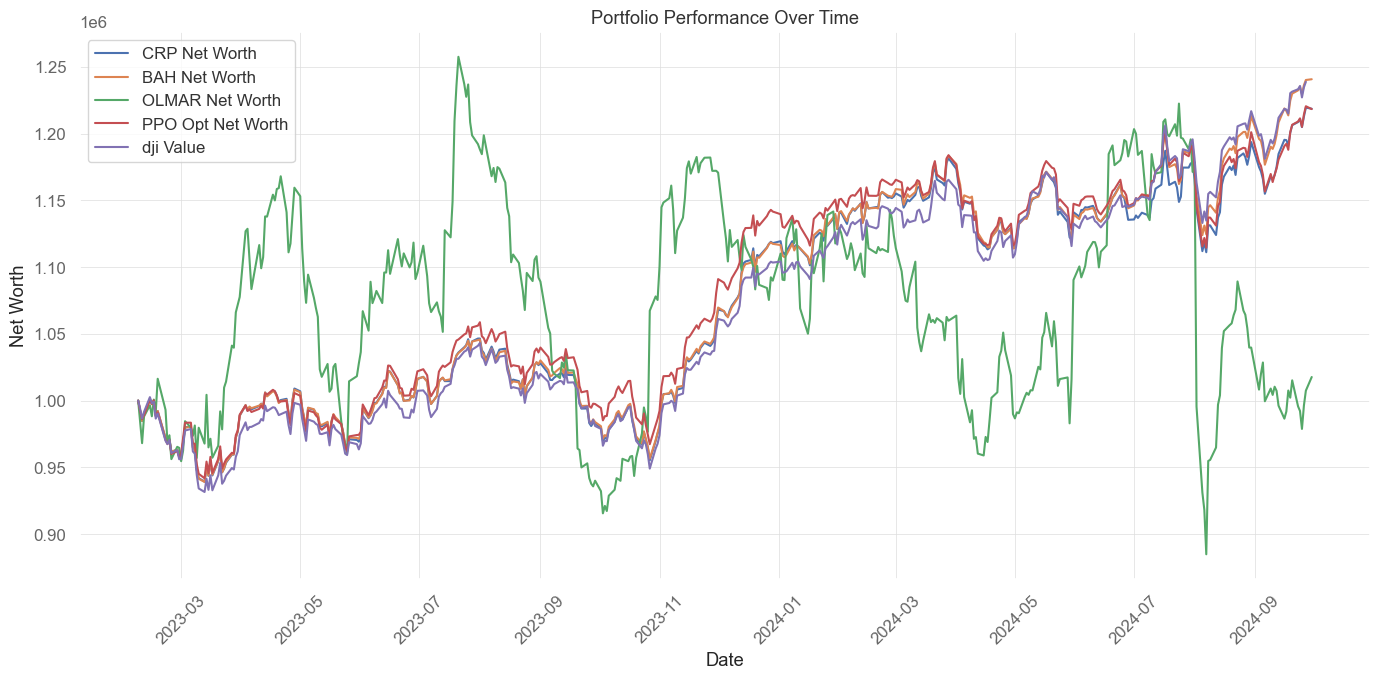

In [27]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

# Plot the DataFrame
plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['bcrp_opt_net_worth'], label='BCRP Net Worth')
# plt.plot(merged_df['Date'], merged_df['CRP_net_worth'], label='CRP Net Worth')# CRP and Opt net worth are basically on the same line
plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP Net Worth')
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH Net Worth')
plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR Net Worth')

# plt.plot(merged_df['Date'], merged_df['opt_net_worth'], label='Opt Net Worth')
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO Opt Net Worth')
# plt.plot(merged_df['Date'], merged_df['ppo_value'], label='PPO Value')
# plt.plot(merged_df['Date'], merged_df['td3_value'], label='TD3 Value')
# plt.plot(merged_df['Date'], merged_df['a2c_value'], label='A2C Value')
plt.plot(merged_df['Date'], merged_df['dji'], label='dji Value')
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
   'PPO': merged_df['ppo_opt_net_worth'].iloc[-1]
}

pprint.pprint(final_returns)

{'BAH': 1240770.125,
 'BCRP OPT': 1605119.125,
 'CRP': 1218665.75,
 'OLMAR': 1017686.4375,
 'PPO': 1218400.0}


In [29]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()

# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()
merged_df['opt_daily_return'] = merged_df['opt_net_worth'].pct_change()
merged_df['ppo_opt_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()

# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP OPT': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP OPT': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'BAH OPT': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),
    'PPO Opt': calculate_sharpe_ratio(merged_df['ppo_opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH OPT': 1.0834195369230009,
 'BCRP OPT': 0.997685853064267,
 'CRP OPT': 0.9639731900535808,
 'OLMAR': 0.13035560564933335,
 'PPO Opt': 0.945605621433222}


In [30]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP Opt': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP Opt': max_drawdown(merged_df['crp_opt_net_worth']),
    'BAH Opt': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR Opt': max_drawdown(merged_df['olmar_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
    'PPO Opt': max_drawdown(merged_df['ppo_opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH Opt': -0.08524969413273342,
 'BCRP Opt': -0.3111121921523836,
 'CRP Opt': -0.08721614497467833,
 'OLMAR Opt': -0.29634723239397975,
 'PPO Opt': -0.08631822334472816}


In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['ppo_opt_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


                 sum_sq     df        F    PR(>F)
Portfolio  3.649928e-07    1.0  0.00749  0.931056
Residual   4.015566e-02  824.0      NaN       NaN


In [32]:
merged_df['ppo_opt_daily_return']

0           NaN
1     -0.007439
2     -0.006556
3      0.003039
4      0.011480
         ...   
409    0.001942
410   -0.005232
411    0.007673
412    0.005128
413   -0.001755
Name: ppo_opt_daily_return, Length: 414, dtype: float64

In [33]:
from scipy import stats

df_ppo = merged_df['ppo_opt_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1     -0.007674
2     -0.007628
3      0.004646
4      0.011987
5     -0.003882
         ...   
409    0.002198
410   -0.004544
411    0.005526
412    0.003133
413    0.000463
Name: BAH_opt_daily_return, Length: 413, dtype: float64
t-statistic: -0.08654308408147186
p-value: 0.931055733240485
